In [1]:
%matplotlib inline

import numpy as np
from scipy.stats import norm
import astropy.constants as const 
import astropy.units as u
import matplotlib
import matplotlib.pylab as plt
import pickle

plt.rcParams['figure.figsize'] = (15.0, 3.0)
plt.rcParams['axes.facecolor'] = 'lightgray'
np.set_printoptions(precision=15)

# User specifications
SNR = 100
noise = False
blaze = True
order_len = 5650.  # determined experimentally, if want symmetric make -1

class LFC:
    '''
    LFC class
    Call with the pump laser frequency [GHz], offset frequency [GHz], and repetition rate [GHz]
    '''
    def __init__(self, pump_wav, offset_freq, rep_rate):
        self.pump_freq = self.convertWavFreq(float(pump_wav))
        self.offset_freq = float(offset_freq)
        self.rep_rate = float(rep_rate)
        
    def getModeSpacing(self):
        '''
        Returns LFC mode spacing
        '''
        return self.rep_rate
    
    def convertWavFreq(self, wavelength):
        '''
        Input wavelength in nm, return frequency in GHz
        '''
        # Check if array
        if isinstance(wavelength, np.ndarray):
            return const.c * u.s / u.m  / wavelength.astype(float)  # Hack to get rid of units
        else: return const.c * u.s / u.m  / float(wavelength)  # Hack to get rid of units
    
    def convertFreqWav(self, frequency):
        '''
        Input frequency in GHz, return wavelength in nm
        '''
        # Check if array
        if isinstance(frequency, np.ndarray):
            return const.c * u.s / u.m / frequency.astype(float)  # Hack to get rid of units
        else: return const.c * u.s / u.m / float(frequency)  # Hack to get rid of units
    
    def getClosestCombLine(self, wavelength):
        '''
        Find closest comb line to specified wavelength.
        '''
        freq = self.convertWavFreq(float(wavelength))
        if (freq < self.pump_freq):
            offset = (self.pump_freq - freq) % self.rep_rate
        elif (freq > self.pump_freq):
            offset = (freq - self.pump_freq) % self.rep_rate
        else:            
            offset = 0.0
        return self.convertFreqWav(freq + offset)
        
    def getWavelengths(self, start_wav, end_wav):
        '''
        Return array of n_points that defines the positions of comb lines in wavelength space
        '''
        start_freq = self.convertWavFreq(start_wav)
        end_freq = self.convertWavFreq(end_wav)
        n_points = int(np.around(np.abs(start_freq - end_freq) / self.rep_rate))
        freqs = np.zeros([1, n_points])
        start_pnt = self.convertWavFreq(self.getClosestCombLine(start_wav))
        for n in range(n_points):
            freqs[0, n] = start_pnt - n * self.rep_rate
        return self.convertFreqWav(freqs)

class Spectrograph:
    '''
    Spectrograph class
    Call with resolution, sampling [pixels], QE, throughput
    '''
    def __init__(self, resolution, sampling, QE, throughput):
        self.res = float(resolution)
        self.samp = float(sampling)
        self.qe = float(QE)
        self.thruput = float(throughput)
        
    def getSampling(self):
        '''
        Public access for pixel sampling
        '''
        return self.samp
        
    def getPlateFactor(self, wavelength):
        '''
        Return spectrograph plate factor at given wavelength
        '''
        return wavelength / (self.res * self.samp)
    
    def getThroughput(self, wavelength):
        '''
        Return spectrograph throughput at given wavelength
        '''
        return self.qe * self.thruput
    
    def getPixelBoundary(self, short_wav, long_wav, order_len):
        '''
        Returns array with pixel boundaries
        '''
        pixel_boundary = np.array([short_wav])
        if (order_len > 0):
            while (pixel_boundary.size < order_len+1):
                pixel_boundary = np.append(pixel_boundary, pixel_boundary[-1] + self.getPlateFactor(pixel_boundary[-1]))
        else:
            while (pixel_boundary[-1] < long_wav): 
                pixel_boundary = np.append(pixel_boundary, pixel_boundary[-1] + self.getPlateFactor(pixel_boundary[-1]))
        return pixel_boundary
    
    def getOrderWavelengths(self, order_num):
        '''
        Returns record array for specified order, only orders 108-110 suppported currently
        Call with order number [108-110] and LFC instance
        '''
        if (order_num == 108):
            #order = np.rec.array([(564.84945, 567.47666, 570.10387, 'Wavelength'),
            #                 ])
            wave = np.array([564.84945, 567.47666, 570.10387])
            
        elif (order_num == 109):
            #order = np.rec.array([(559.69123, 562.27045, 564.84967, 'Wavelength'),
            #                  ])                
            wave = np.array([559.69123, 562.27045, 564.84967])
        elif (order_num == 110):
            #order = np.rec.array([(554.62636, 557.15890, 559.69144, 'Wavelength'),
            #                 ])
            wave = np.array([554.62636, 557.15890, 559.69144])
        else: 
            print "Incompatible order number"
            return -1
        
        return wave
    
    def addBlaze(self, order_info, data, wavelengths):
        '''
        Function to add Gaussian like blaze function to orders
        Call with generated data and associated order info
        Returns intensity of data with blaze envelope
        '''
        sigma = (order_info[2] - order_info[0]) / (2.0*np.sqrt(2.0*np.log(2)))  # Assume FWHM of blaze is FSR of order
        print(order_info)
        return data * np.exp(-(wavelengths - order_info[1])**2 / (2.0*sigma**2))
        
    def getData(self, wave, lfc_inst, intensity, blaze, order_len):    
        '''
        Function to simulate lfc data
        Call with order info, lfc instance, comb line intensity, boolean for blaze function
        Return pixel intensity for order and mean wavelength per pixel
        '''
        #bounds = self.getPixelBoundary(wave[0], wave[2]) 

        bounds = self.getPixelBoundary(wave[0] - self.getPlateFactor(wave[0]*30), 
                                       wave[2] + self.getPlateFactor(wave[2]*30), 
                                       order_len)  
        data = np.zeros(bounds.size-1)  # empty pixel array
        # find lfc lines for given order, extend beyond order to allow for overlap
        lfc_loc = lfc_inst.getWavelengths(wave[0]-self.getPlateFactor(wave[0])*100, 
                                          wave[2]+self.getPlateFactor(wave[2])*100)
        print('bounds', bounds)
        for n in range(data.size):
            # for each pixel, compute CDF(pix_start) - CDF(pix_end) with array of lfc line locations acting as Gaussian series
            data[n] = np.sum( intensity * (self.area_under_norm_dist(bounds[n], bounds[n+1], lfc_loc, 
                                                self.getPlateFactor(bounds[n])*self.getSampling())
                            ))
        mean_wave_pix = bounds[0:bounds.size-1] + (bounds[1:bounds.size] -bounds[0:bounds.size-1])/2.0
        if blaze: data = self.addBlaze(wave, data, mean_wave_pix)
        return data, mean_wave_pix                            
    
    def area_under_norm_dist(self, a, b, loc, fwhm):
        # Returns area under normal distribution centered at loc with fwhm on boundary (a,b)
        # calculates CDF(b) - CDF(a) 
        # loc may be an array
        sigma = fwhm / (2.0*np.sqrt(2.0*np.log(2)))  # [pixels]
        area = norm.cdf(b, loc, scale=sigma) - norm.cdf(a, loc, scale=sigma)
        return area



#
# Instantiate spectrograph and lfc
#
spx = Spectrograph(150000.0, 4.0, 1.0, 1.0)
lfc = LFC(600.0, 10.0, 14.0)

#
# Generate data
#
signal = SNR**2 * spx.getSampling()  
for_pickling = {}
# get information on orders
orders = np.array([110, 109, 108])
order_info = np.zeros([orders.size, orders.size])
# Go through each order, create data, get lfc truth values, add to dictionary
for n in range(orders.size):
    order_info[n,:] = spx.getOrderWavelengths(orders[n])
    data, wavelengths = spx.getData(order_info[n,:], lfc, signal, blaze, order_len)
    print wavelengths.size
    if noise: data += np.random.poisson(data)
    pixel_data = np.array([wavelengths, data])
    lfc_truth = np.array([lfc.getWavelengths(order_info[n,0]-spx.getPlateFactor(order_info[n,0])*20, 
                                            order_info[n,2]+spx.getPlateFactor(order_info[n,2])*20)])
    string = 'order%d' % orders[n]
    string2 = 'lfc%d' % orders[n]
    data = {'wavelength': pixel_data[0,:], 'intensity': pixel_data[1,:], 'lfc': lfc_truth}
    for_pickling[string] = data
    
title = '%dSNR.p' % SNR
pickle.dump(for_pickling, open(title, 'wb'))




('bounds', array([ 554.598628682000026,  554.599553013047853,  554.60047734563625 ,
       ...,  559.843895057149325,  559.844828130307747,  559.84576120502129 ]))
[ 554.626359999999977  557.158900000000017  559.691439999999943]
5650
('bounds', array([ 559.663245438499985,  559.664178210575756,  559.665110984206081,
       ...,  564.956411795000804,  564.957353389020454,
        564.958294984609438]))
[ 559.691230000000019  562.270449999999983  564.849669999999946]
5650
('bounds', array([ 564.821207527500064,  564.822148896179328,  564.823090266427471,
       ...,  570.163156704066978,  570.164106975994855,
        570.165057249506503]))
[ 564.849450000000047  567.476660000000038  570.103870000000029]
5650


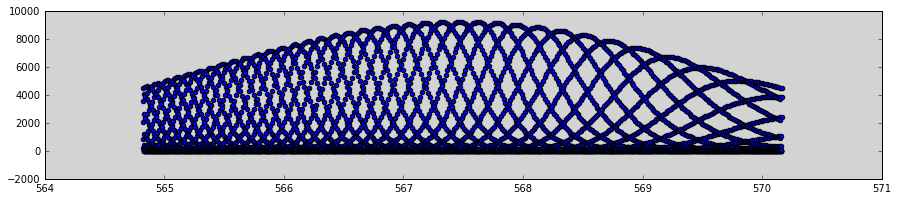

In [2]:
%matplotlib inline

import pickle
import matplotlib
import matplotlib.pylab as plt

file = '100SNR.p'
d = pickle.load(open(file, 'rb'))
plt.figure(figsize=(15, 3))
plt.scatter(d['order108']['wavelength'], d['order108']['intensity'])
# plt.xlim(565, 565.01)